In [2]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import mne
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
from IPython.display import clear_output

ModuleNotFoundError: No module named 'matplotlib'

In [2]:
sr = 1000
edf_path = "C:\\Users\\Rotem\\Data\\%s_for_tag_filtered_fix_tag.edf"

### segment Lilach tags to 1 sec intervals

In [197]:
def get_metrics(cm):
    if len(cm) == 0:
        cm = np.zeros((2,2), dtype=int)
    if np.squeeze(cm).ndim < 2:
        new_cm = np.zeros((2,2), dtype=int)
        new_cm[1, 1] = int(cm[0][0])
        cm = new_cm
    numerator = cm[0, 0] + cm[1, 1]
    denominator = cm[0, 0] + cm[1, 1] + cm[0, 1] + cm[1, 0]
    accuracy = numerator / denominator
    precision = cm[1, 1] / (cm[1, 1] + cm[0, 1])
    recall = cm[1, 1] / (cm[1, 1] + cm[1, 0])
    numerator = precision * recall
    denominator = (0.25 * precision) + recall
    f_score = 1.25 * numerator / denominator
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f_score': f_score}

# segment Lilach tags to 1 sec intervals
def format_raw(subj, channels): 
    epochs, epochs_random = [], []
    window_size = sr
    raw = mne.io.read_raw_edf(edf_path % subj)
    spikes = raw.annotations
    spikes_df = pd.DataFrame(spikes)
    end_onset = list(spikes_df[spikes_df['description'].str.contains('END')]['onset'])[0]
    spikes_df = spikes_df[spikes_df['description'].str.contains(channels[0][0] + 't')]
    spikes_df = spikes_df.drop_duplicates(subset=['onset'])
    complete_spikes_df = spikes_df[spikes_df['onset'] < end_onset]

    # from first tags round- only some spikes here and there
    random_spikes_df = spikes_df[spikes_df['onset'] > end_onset]
    raw_data = raw.copy().pick_channels(channels).resample(sr).get_data()
    for onset in random_spikes_df['onset']:
        epochs_random.append(raw_data[:, int(onset * sr - window_size / 2) : int (onset * sr + window_size / 2)].T)
    y_windows_random = np.full(len(epochs_random), 1)

    # from second tags round- complete data
    raw_data = raw.crop(tmax=end_onset).pick_channels(channels).resample(sr).get_data()

    for i in range(0, raw_data.shape[1], window_size):
        curr_block = raw_data[:, i: i  + window_size]
        if i + window_size < raw_data.shape[1]:
            epochs.append(curr_block.T)

    y_windows = np.zeros(len(epochs))
    for onset in complete_spikes_df['onset']:
        y_windows[int(onset * 1000 / window_size)] = 1

    epochs = np.concatenate((epochs, epochs_random))
    y_windows = np.concatenate((y_windows, y_windows_random))

    return epochs, y_windows

In [200]:
y_all = np.empty(0)
x_all, x_all_norm, x_all_clean_norm = None, None, None
for subj in ['38', '396', '398', '402', '406', '415', '416']:
    for channel in ['RAH1', 'LAH1']:
        if not ((subj == '396' and channel == 'RAH1') or (subj == '38' and channel == 'LAH1')):
            x, y = format_raw(subj, [channel])
            y_all = np.concatenate((y_all, y))
            # Normalize and save the mean and std we get
            subj_clean_mean = x[y==0].mean()
            subj_clean_std = x[y==0].std()
            subj_clean_norm = (x - subj_clean_mean) / subj_clean_std
            subj_mean = x.mean()
            subj_std = x.std()
            subj_norm = (x - subj_mean) / subj_std
#             df_training_value = (x[y==0] - training_mean) / training_std
#             df_test_value = (x - healty_mean) / healty_std
            if x_all is None:
                x_all = x
                x_all_norm = subj_norm
                x_all_clean_norm = subj_clean_norm
            else:
                x_all = np.concatenate((x_all, x))
                x_all_norm = np.concatenate((x_all_norm, subj_norm))
                x_all_clean_norm = np.concatenate((x_all_clean_norm, subj_clean_norm))
                
clear_output()

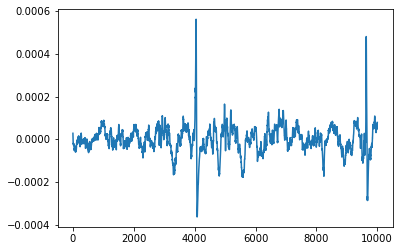

In [139]:
plt.plot(np.concatenate(x_all[:10]))

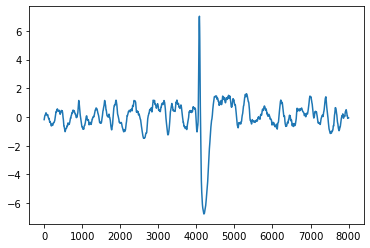

In [182]:
plt.plot(np.concatenate(x_all_norm[250:258]))

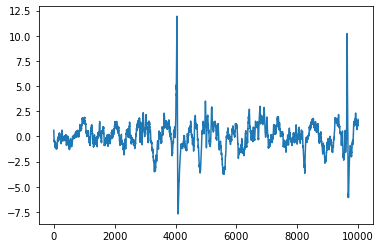

In [141]:
plt.plot(np.concatenate(x_all_clean_norm[:10]))

In [187]:
x_all_norm.shape

(2410, 1000, 1)

In [192]:
x_train, x_test, y_train, y_test = train_test_split(x_all_norm, y_all, stratify=y_all, random_state=30)

In [205]:
x_train

array([[[-2.07210998],
        [-2.07132661],
        [-2.06378422],
        ...,
        [-1.54548925],
        [-1.53873037],
        [-1.53583299]],

       [[ 1.18397767],
        [ 1.24305303],
        [ 1.22637881],
        ...,
        [ 0.09062278],
        [ 0.12861207],
        [ 0.14898058]],

       [[ 0.05268651],
        [ 0.07618549],
        [ 0.09601658],
        ...,
        [-0.36639384],
        [-0.36301065],
        [-0.36587295]],

       ...,

       [[ 0.71925286],
        [ 0.71558503],
        [ 0.71910423],
        ...,
        [ 0.10116712],
        [ 0.09092805],
        [ 0.08196803]],

       [[ 0.741683  ],
        [ 0.77901934],
        [ 0.79862079],
        ...,
        [ 0.24633996],
        [ 0.2311745 ],
        [ 0.20326041]],

       [[ 0.24160723],
        [ 0.27745842],
        [ 0.3025001 ],
        ...,
        [-1.14246658],
        [-1.14656341],
        [-1.14589979]]])

In [144]:
num_classes = len(np.unique(y_train))

In [145]:
# idx = np.random.permutation(len(x_train))
# x_train = x_train[idx]
# y_train = y_train[idx]

In [146]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=x_train.shape[1:])
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [147]:
epochs = 500
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/500
46/46 [==============================] - 1s 19ms/step - loss: 0.3351 - sparse_categorical_accuracy: 0.8740 - val_loss: 0.4374 - val_sparse_categorical_accuracy: 0.8674 - lr: 0.0010
Epoch 2/500
46/46 [==============================] - 1s 13ms/step - loss: 0.2736 - sparse_categorical_accuracy: 0.8934 - val_loss: 0.3603 - val_sparse_categorical_accuracy: 0.8674 - lr: 0.0010
Epoch 3/500
46/46 [==============================] - 1s 13ms/step - loss: 0.2670 - sparse_categorical_accuracy: 0.8969 - val_loss: 0.3585 - val_sparse_categorical_accuracy: 0.8702 - lr: 0.0010
Epoch 4/500
46/46 [==============================] - 1s 12ms/step - loss: 0.2531 - sparse_categorical_accuracy: 0.9052 - val_loss: 0.3855 - val_sparse_categorical_accuracy: 0.8702 - lr: 0.0010
Epoch 5/500
46/46 [==============================] - 1s 13ms/step - loss: 0.2668 - sparse_categorical_accuracy: 0.8962 - val_loss: 0.3559 - val_sparse_categorical_accuracy: 0.8729 - lr: 0.0010
Epoch 6/500
46/46 [================

46/46 [==============================] - 1s 12ms/step - loss: 0.1871 - sparse_categorical_accuracy: 0.9329 - val_loss: 0.1625 - val_sparse_categorical_accuracy: 0.9420 - lr: 0.0010
Epoch 44/500
46/46 [==============================] - 1s 12ms/step - loss: 0.1889 - sparse_categorical_accuracy: 0.9329 - val_loss: 0.2396 - val_sparse_categorical_accuracy: 0.9227 - lr: 0.0010
Epoch 45/500
46/46 [==============================] - 1s 12ms/step - loss: 0.1811 - sparse_categorical_accuracy: 0.9391 - val_loss: 0.1540 - val_sparse_categorical_accuracy: 0.9420 - lr: 0.0010
Epoch 46/500
46/46 [==============================] - 1s 12ms/step - loss: 0.1887 - sparse_categorical_accuracy: 0.9363 - val_loss: 0.1614 - val_sparse_categorical_accuracy: 0.9392 - lr: 0.0010
Epoch 47/500
46/46 [==============================] - 1s 12ms/step - loss: 0.1893 - sparse_categorical_accuracy: 0.9343 - val_loss: 0.1841 - val_sparse_categorical_accuracy: 0.9309 - lr: 0.0010
Epoch 48/500
46/46 [=======================

46/46 [==============================] - 1s 12ms/step - loss: 0.1627 - sparse_categorical_accuracy: 0.9419 - val_loss: 0.1731 - val_sparse_categorical_accuracy: 0.9337 - lr: 0.0010
Epoch 86/500
46/46 [==============================] - 1s 13ms/step - loss: 0.1586 - sparse_categorical_accuracy: 0.9460 - val_loss: 0.1315 - val_sparse_categorical_accuracy: 0.9475 - lr: 0.0010
Epoch 87/500
46/46 [==============================] - 1s 12ms/step - loss: 0.1472 - sparse_categorical_accuracy: 0.9426 - val_loss: 0.1320 - val_sparse_categorical_accuracy: 0.9503 - lr: 0.0010
Epoch 88/500
46/46 [==============================] - 1s 12ms/step - loss: 0.1577 - sparse_categorical_accuracy: 0.9529 - val_loss: 0.1442 - val_sparse_categorical_accuracy: 0.9475 - lr: 0.0010
Epoch 89/500
46/46 [==============================] - 1s 12ms/step - loss: 0.1512 - sparse_categorical_accuracy: 0.9460 - val_loss: 0.1724 - val_sparse_categorical_accuracy: 0.9365 - lr: 0.0010
Epoch 90/500
46/46 [=======================

46/46 [==============================] - 1s 12ms/step - loss: 0.1383 - sparse_categorical_accuracy: 0.9529 - val_loss: 0.1168 - val_sparse_categorical_accuracy: 0.9613 - lr: 0.0010
Epoch 128/500
46/46 [==============================] - 1s 13ms/step - loss: 0.1402 - sparse_categorical_accuracy: 0.9522 - val_loss: 0.1132 - val_sparse_categorical_accuracy: 0.9586 - lr: 0.0010
Epoch 129/500
46/46 [==============================] - 1s 12ms/step - loss: 0.1438 - sparse_categorical_accuracy: 0.9522 - val_loss: 0.2219 - val_sparse_categorical_accuracy: 0.9309 - lr: 0.0010
Epoch 130/500
46/46 [==============================] - 1s 12ms/step - loss: 0.1429 - sparse_categorical_accuracy: 0.9509 - val_loss: 0.1362 - val_sparse_categorical_accuracy: 0.9475 - lr: 0.0010
Epoch 131/500
46/46 [==============================] - 1s 12ms/step - loss: 0.1501 - sparse_categorical_accuracy: 0.9488 - val_loss: 0.1248 - val_sparse_categorical_accuracy: 0.9558 - lr: 0.0010
Epoch 132/500
46/46 [==================

Epoch 169/500
46/46 [==============================] - 1s 12ms/step - loss: 0.1274 - sparse_categorical_accuracy: 0.9536 - val_loss: 0.1098 - val_sparse_categorical_accuracy: 0.9613 - lr: 5.0000e-04
Epoch 170/500
46/46 [==============================] - 1s 12ms/step - loss: 0.1285 - sparse_categorical_accuracy: 0.9557 - val_loss: 0.1412 - val_sparse_categorical_accuracy: 0.9475 - lr: 5.0000e-04
Epoch 171/500
46/46 [==============================] - 1s 12ms/step - loss: 0.1342 - sparse_categorical_accuracy: 0.9502 - val_loss: 0.1151 - val_sparse_categorical_accuracy: 0.9613 - lr: 5.0000e-04
Epoch 172/500
46/46 [==============================] - 1s 12ms/step - loss: 0.1199 - sparse_categorical_accuracy: 0.9543 - val_loss: 0.1086 - val_sparse_categorical_accuracy: 0.9641 - lr: 5.0000e-04
Epoch 173/500
46/46 [==============================] - 1s 12ms/step - loss: 0.1275 - sparse_categorical_accuracy: 0.9550 - val_loss: 0.1104 - val_sparse_categorical_accuracy: 0.9586 - lr: 5.0000e-04
Epoch

In [148]:
model = keras.models.load_model("best_model.h5")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

19/19 [==============================] - 0s 16ms/step - loss: 0.1472 - sparse_categorical_accuracy: 0.9536
Test accuracy 0.9535654783248901
Test loss 0.14717961847782135


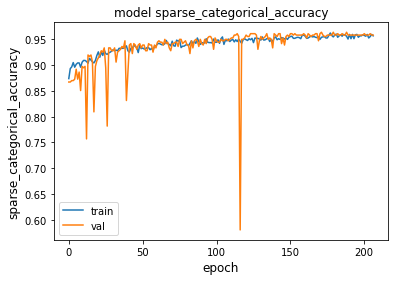

In [149]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [150]:
y_pred = model.predict(x_test)

In [151]:
pd.DataFrame(y_pred.T)

,0,1,2,3,4,5,6,7,8,9,...,593,594,595,596,597,598,599,600,601,602
0,0.978733,0.985762,0.980185,0.992074,0.733562,0.990988,0.962508,0.967946,0.975426,0.001431,...,0.992636,0.957943,0.925871,0.989101,0.982182,0.992918,0.977765,0.978376,0.981171,0.86908
1,0.021267,0.014238,0.019815,0.007926,0.266438,0.009012,0.037492,0.032054,0.024574,0.998569,...,0.007364,0.042057,0.074129,0.010899,0.017818,0.007082,0.022235,0.021624,0.018829,0.13092


In [160]:
i_pred[0]

array([  9,  16,  25,  33,  37,  39,  41,  46,  56,  66,  92,  93, 103,
       125, 135, 147, 151, 154, 159, 161, 179, 186, 193, 196, 197, 199,
       200, 202, 211, 212, 213, 217, 229, 254, 256, 271, 280, 292, 296,
       298, 300, 301, 306, 312, 330, 333, 339, 342, 355, 365, 372, 381,
       398, 408, 417, 419, 420, 432, 433, 437, 438, 452, 456, 468, 482,
       524, 531, 535, 537, 540, 562, 564, 579, 580], dtype=int64)

In [179]:
y_test.nonzero()[0]

array([  9,  16,  17,  33,  37,  39,  41,  46,  56,  66,  77,  92, 103,
       125, 135, 147, 150, 151, 159, 161, 176, 179, 186, 193, 196, 197,
       199, 200, 202, 203, 206, 211, 212, 213, 217, 229, 241, 254, 256,
       271, 280, 292, 296, 298, 300, 301, 306, 312, 328, 330, 333, 335,
       337, 340, 342, 357, 358, 365, 372, 381, 398, 408, 414, 417, 420,
       432, 433, 437, 438, 441, 452, 456, 482, 511, 524, 526, 535, 537,
       540, 562, 564, 579, 580, 583, 586, 602], dtype=int64)

Text(0.45, 0.1, 'Predicted label')

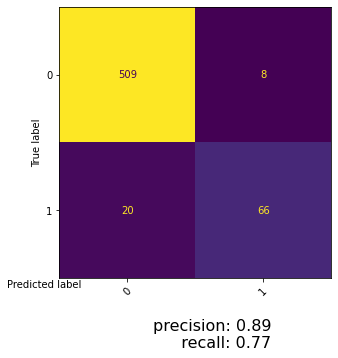

In [153]:
# cf_matrix = confusion_matrix(y_test, [p > 0.80 for p in y_pred[1]])
cf_matrix = confusion_matrix(y_test, [p > 0.5 for p in y_pred.T[1]])
metrics = get_metrics(cf_matrix)
disp = ConfusionMatrixDisplay(cf_matrix)
f, axes = plt.subplots(1, 1, figsize=(10, 5), sharey='row')
disp.plot(ax=axes, xticks_rotation=45)
text = """precision: {0}
          recall: {1}""".format(str('{0:.2f}'.format(metrics['precision'])), str('{0:.2f}'.format(metrics['recall'])))
axes.annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
            xytext=(-60, -40), textcoords='offset points',
            ha='right', va='top')
disp.im_.colorbar.remove()
disp.ax_.set_xlabel('')

f.text(0.45, 0.1, 'Predicted label', ha='left')

In [106]:
# # all test predictions
# x_test_reshape = x_test.reshape(x_test.shape[0], x_test.shape[1])
# i_pred = np.where(y_pred.T[1]>0.5)
# for i in i_pred[0]:
#     plt.figure()
#     plt.title(i)    
#     pred_view = np.concatenate(x_test_reshape[i - 4: i + 5])
#     plt.plot(pred_view)
#     plt.plot(range(4000, 5000), x_test_reshape[i], c='red')

C:\Users\Rotem\AppData\Local\Temp\2/ipykernel_18152/1215923762.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


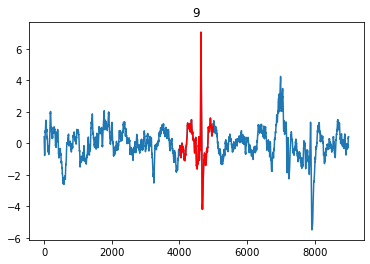

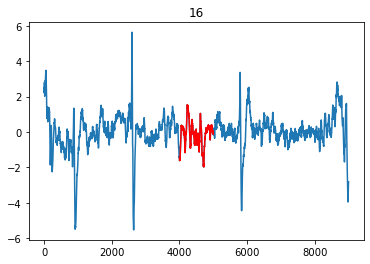

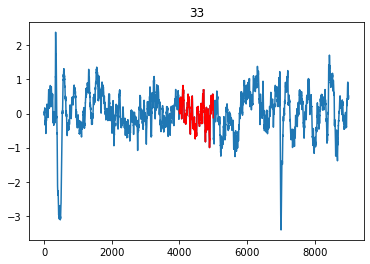

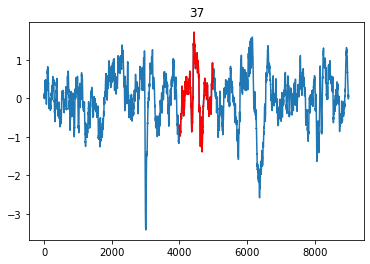

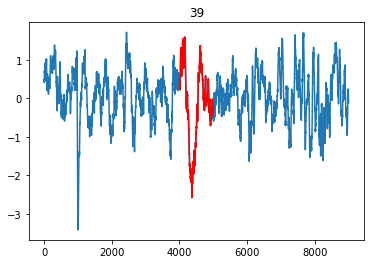

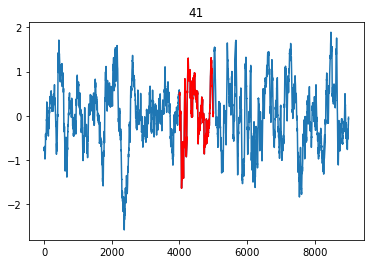

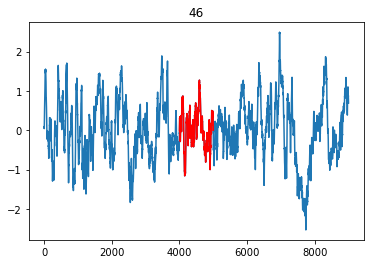

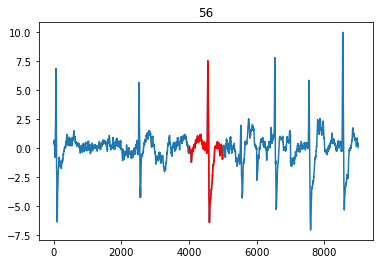

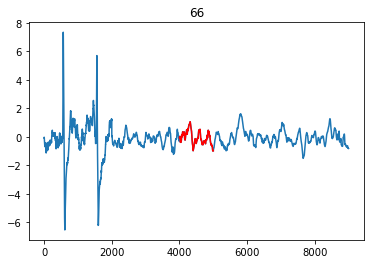

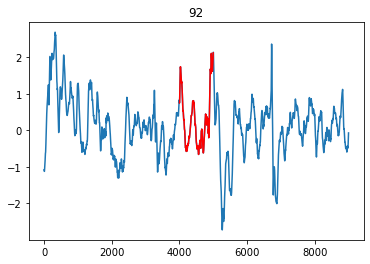

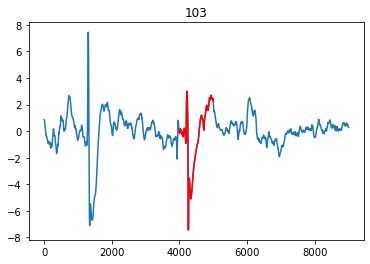

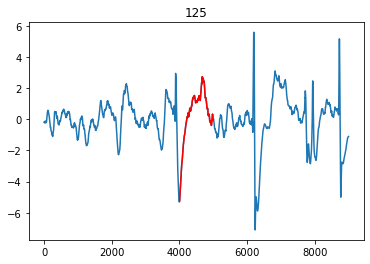

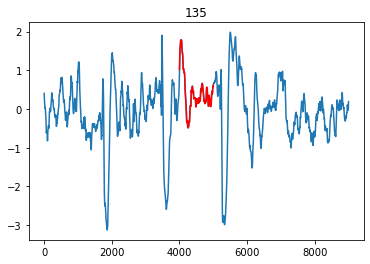

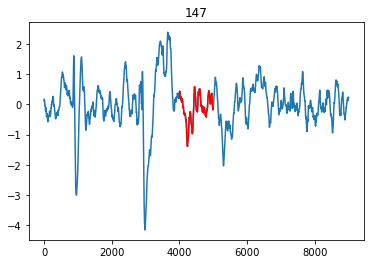

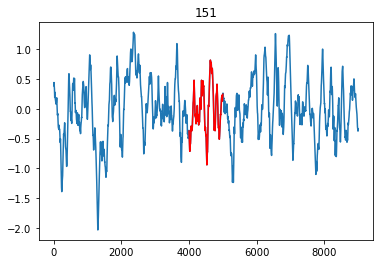

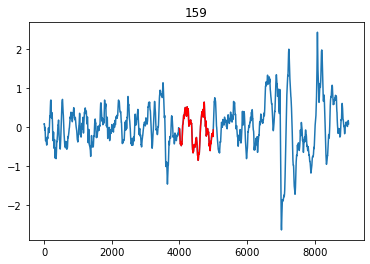

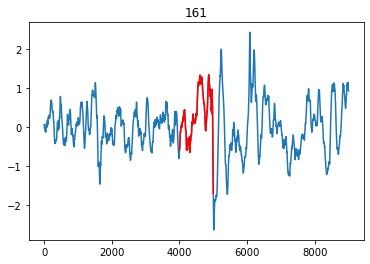

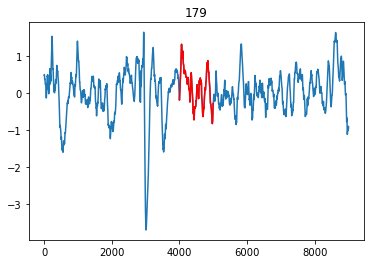

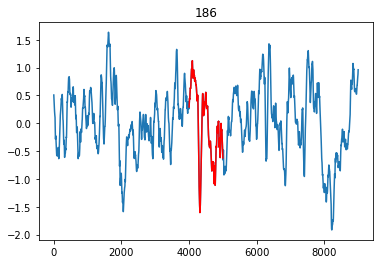

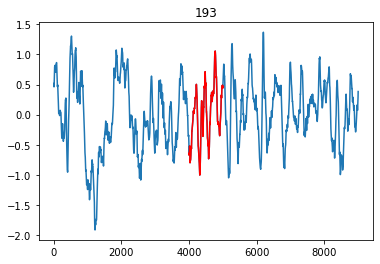

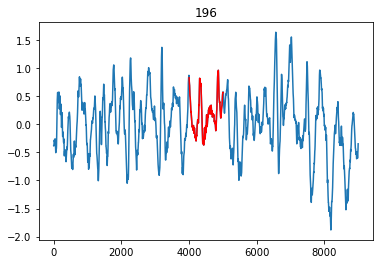

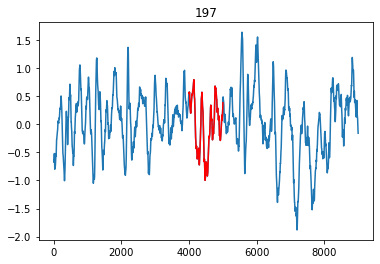

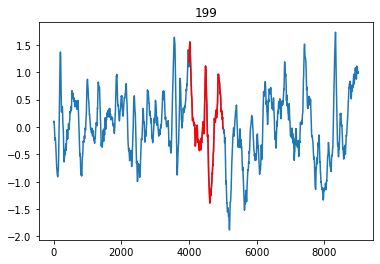

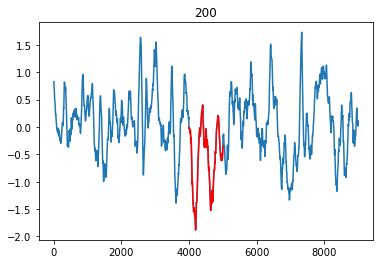

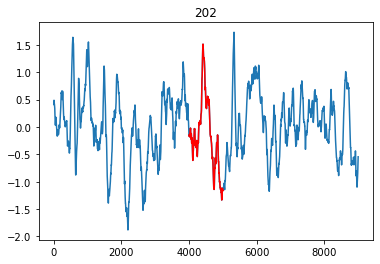

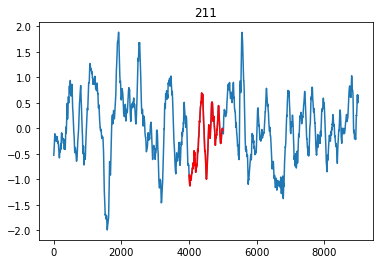

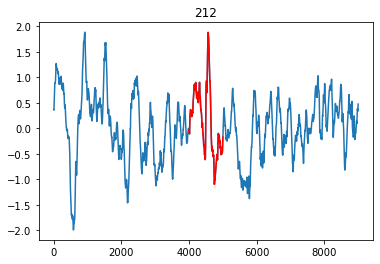

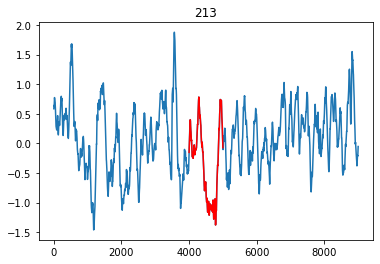

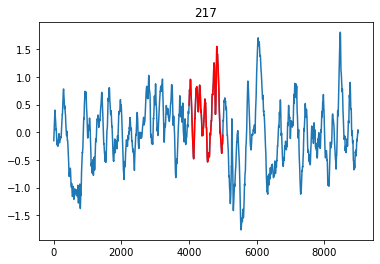

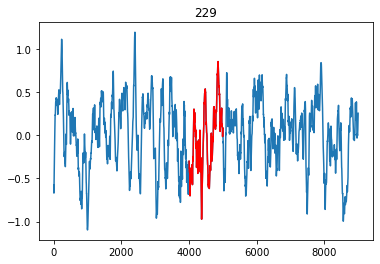

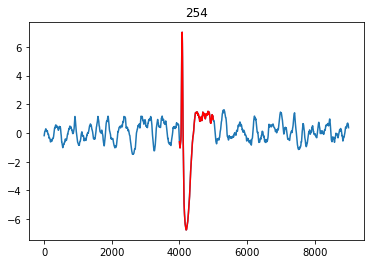

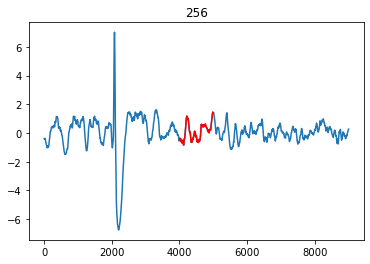

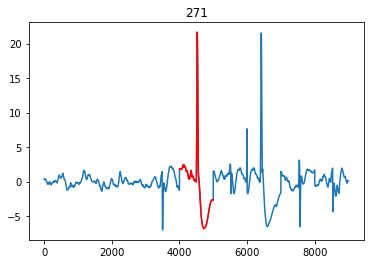

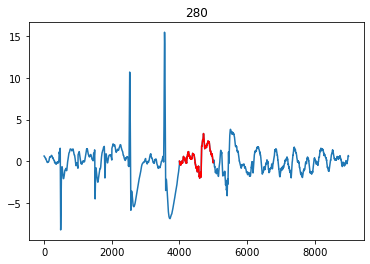

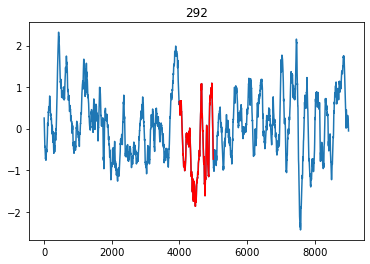

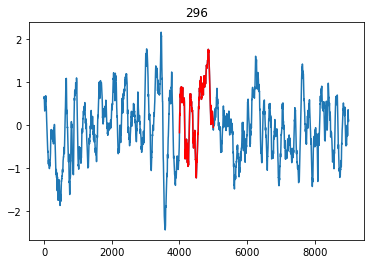

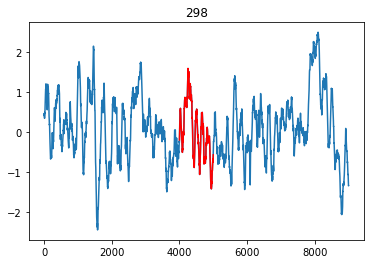

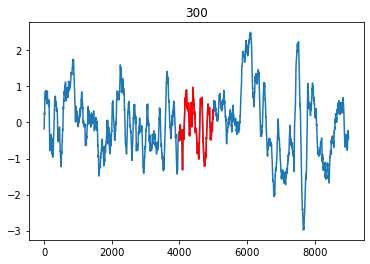

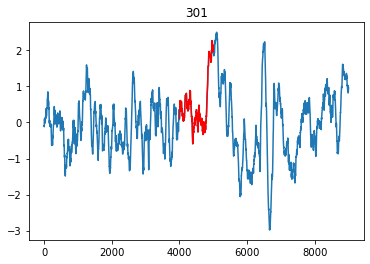

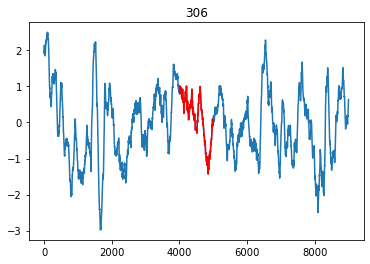

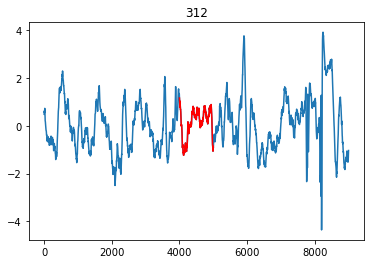

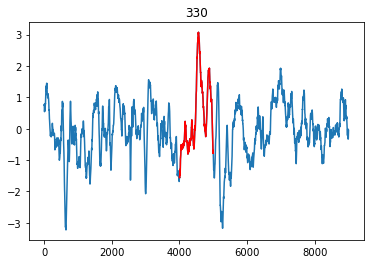

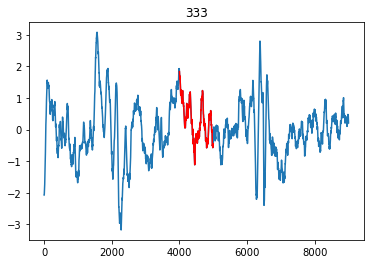

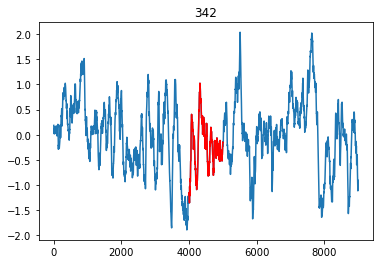

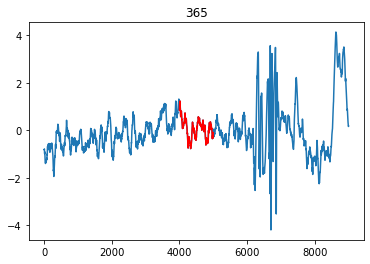

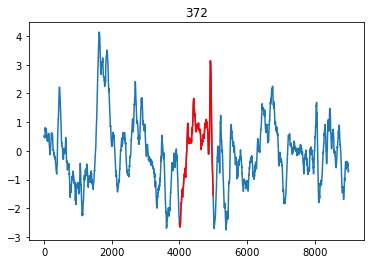

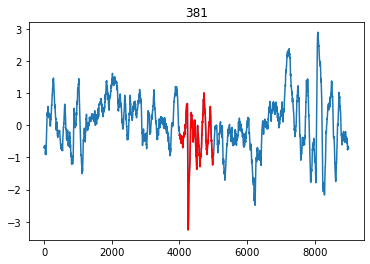

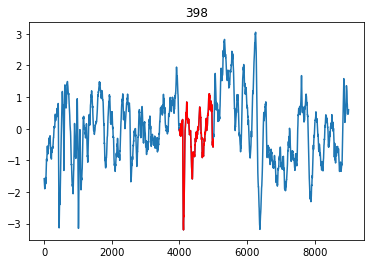

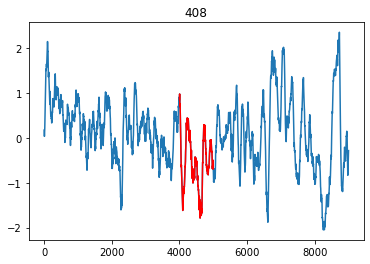

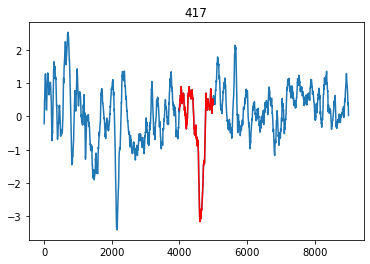

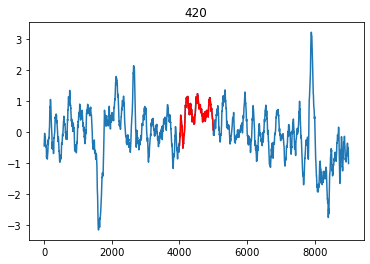

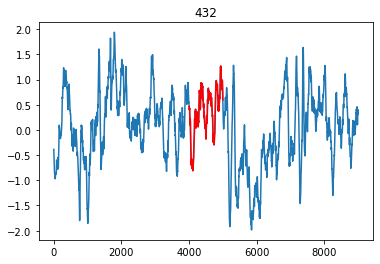

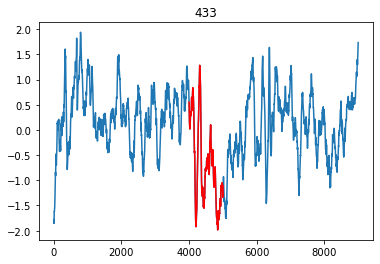

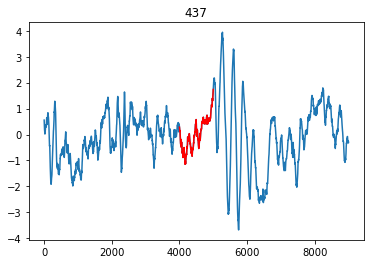

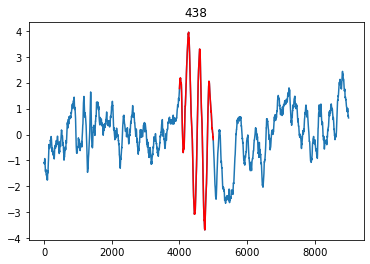

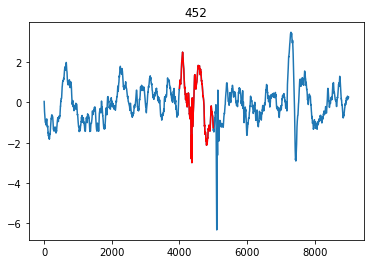

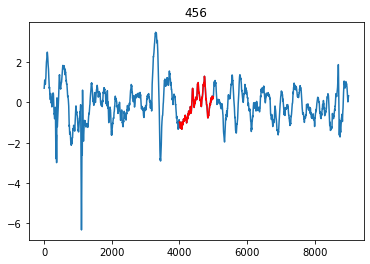

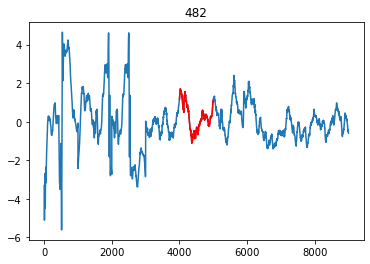

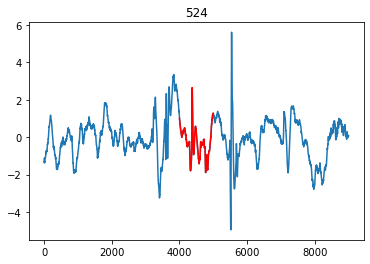

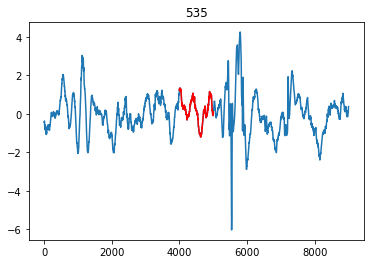

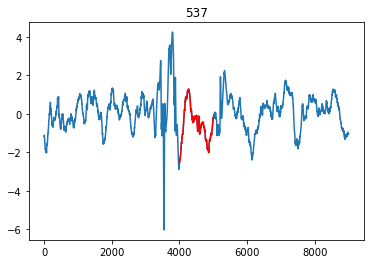

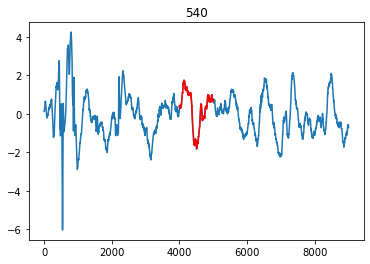

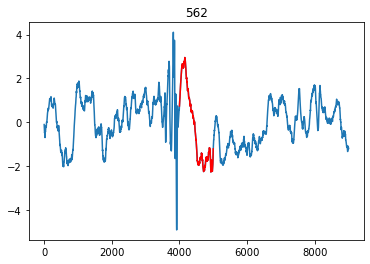

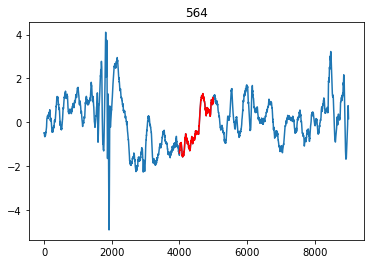

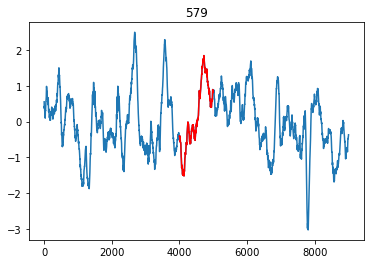

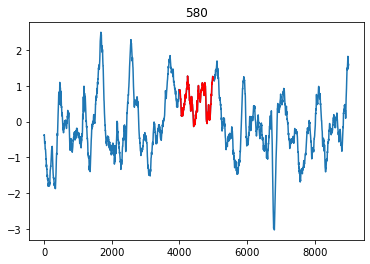

In [180]:
# True positives
i_pred = np.where(y_pred.T[1]>0.5)
true_pos = [i for i in y_test.nonzero()[0] if i in i_pred[0]]
for i in true_pos:
    plt.figure()
    plt.title(i)    
    pred_view = np.concatenate(x_all_norm[i - 4: i + 5])
    plt.plot(pred_view)
    plt.plot(range(4000, 5000), x_all_norm[i], c='red')

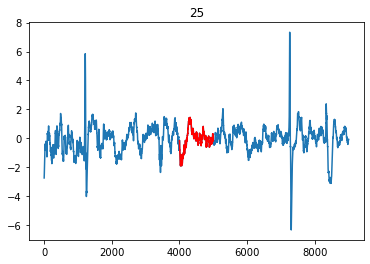

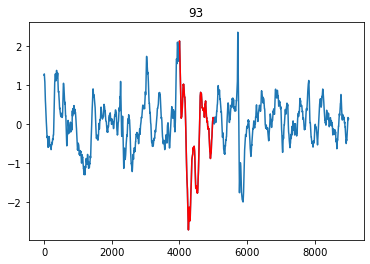

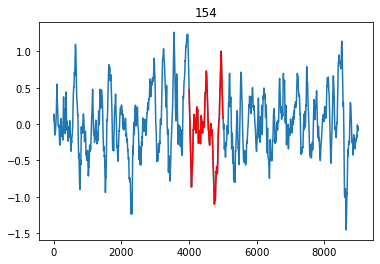

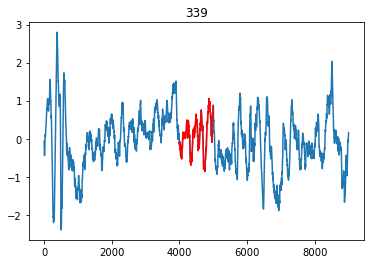

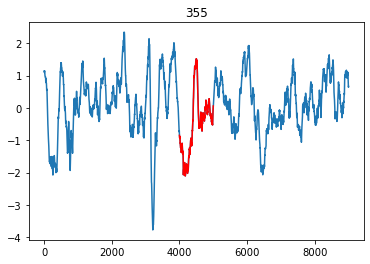

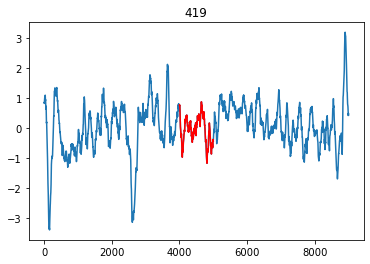

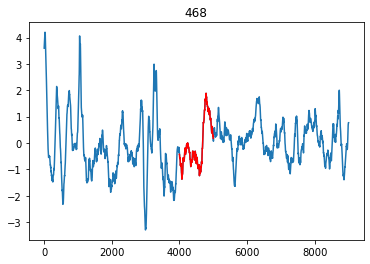

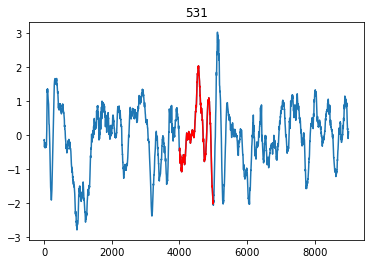

In [183]:
# False positive
false_pos = [i for i in i_pred[0] if i not in y_test.nonzero()[0]]
for i in false_pos:
    plt.figure()
    plt.title(i)    
    pred_view = np.concatenate(x_all_norm[i - 4: i + 5])
    plt.plot(pred_view)
    plt.plot(range(4000, 5000), x_all_norm[i], c='red')

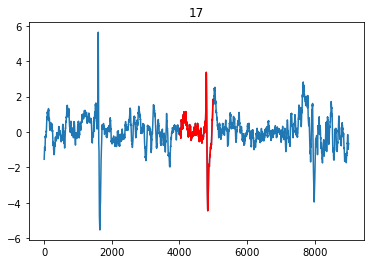

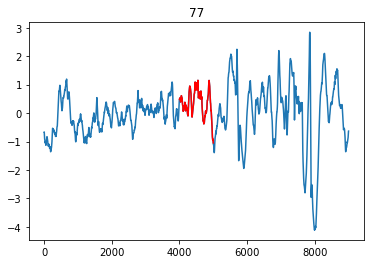

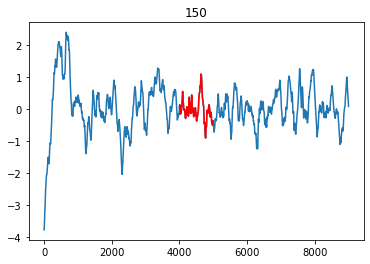

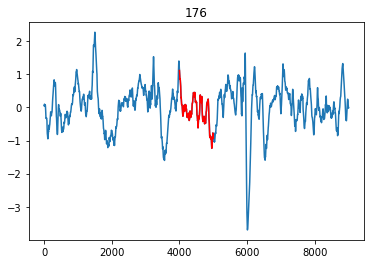

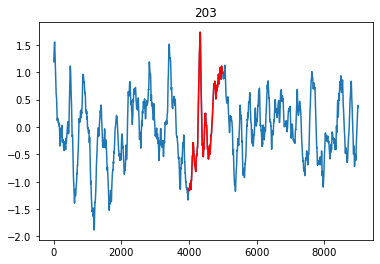

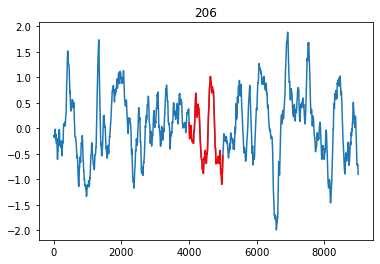

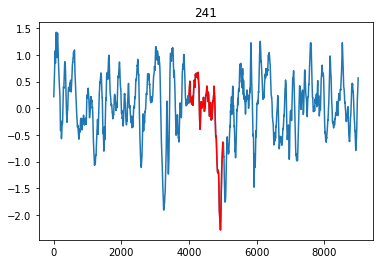

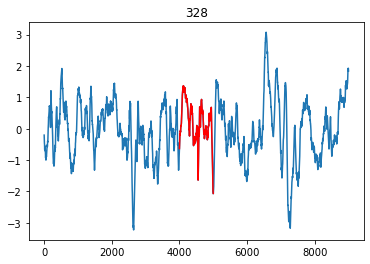

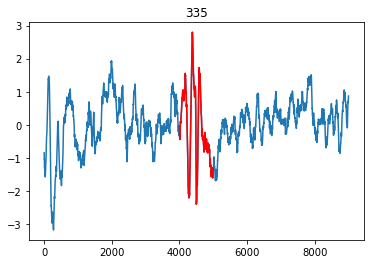

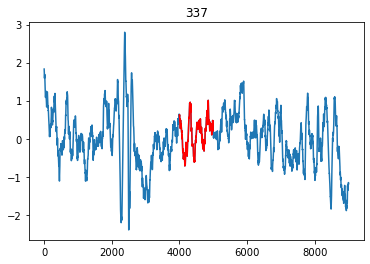

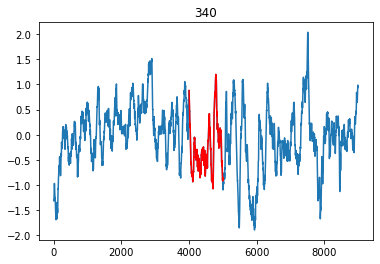

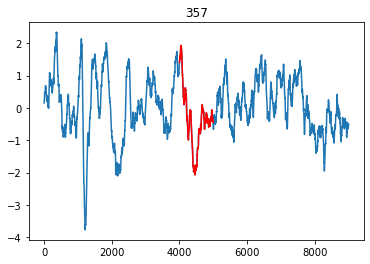

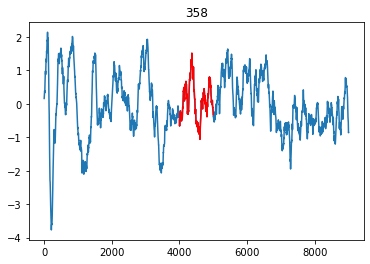

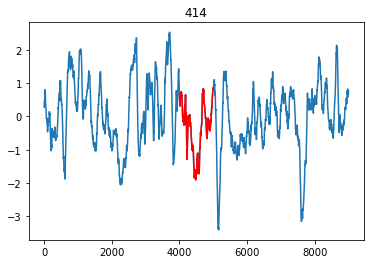

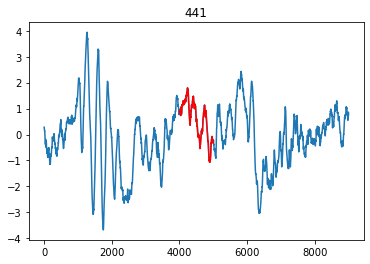

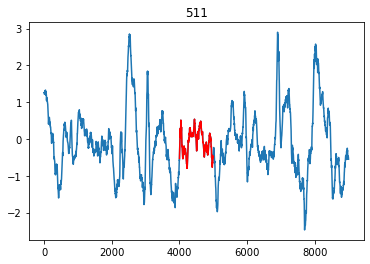

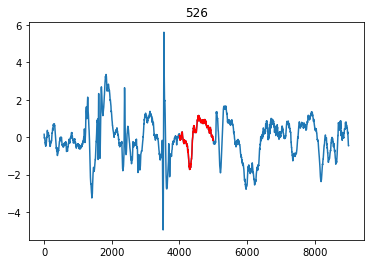

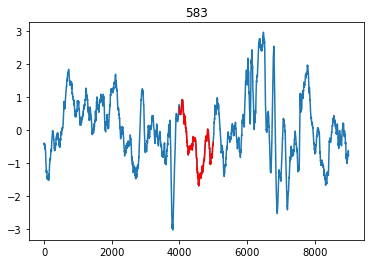

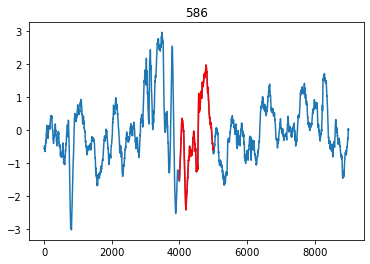

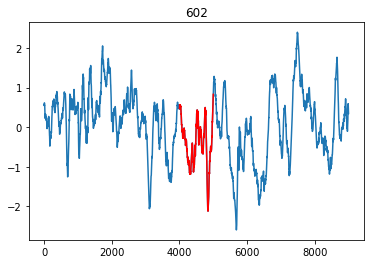

In [184]:
# False negative (miss)
missed = [i for i in y_test.nonzero()[0] if i not in i_pred[0]]
for i in missed:
    plt.figure()
    plt.title(i)    
    pred_view = np.concatenate(x_all_norm[i - 4: i + 5])
    plt.plot(pred_view)
    plt.plot(range(4000, 5000), x_all_norm[i], c='red')

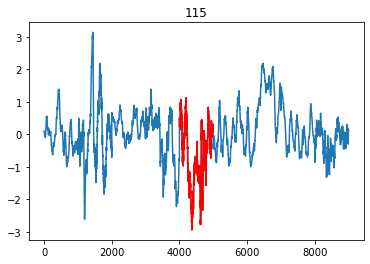

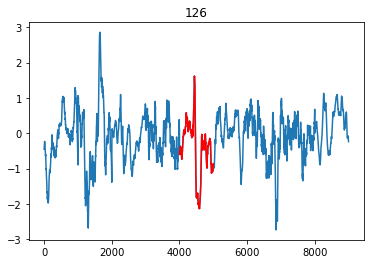

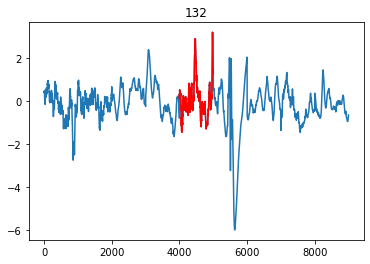

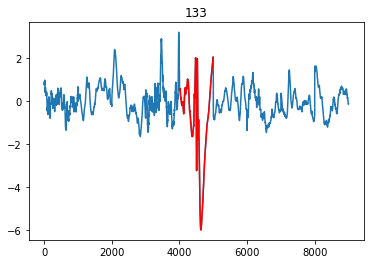

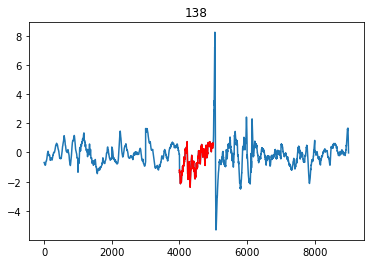

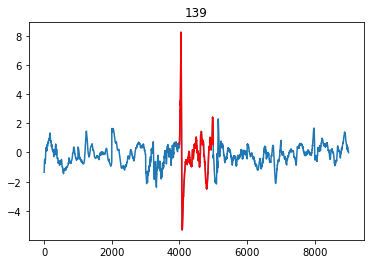

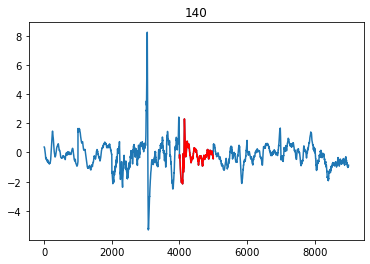

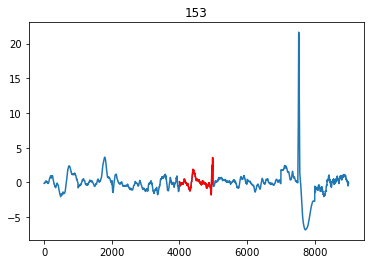

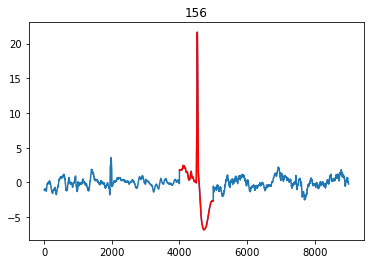

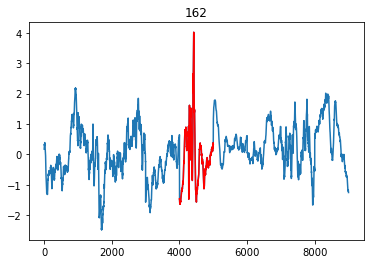

In [207]:
# Train data
x_train_reshape = x_train.reshape(x_train.shape[0], x_train.shape[1])
for i in y_train.nonzero()[0][20:30]:
    plt.figure()
    plt.title(i)
    pred_view = np.concatenate(x_train_reshape[i - 4: i + 5])
    plt.plot(pred_view)
    plt.plot(range(4000, 5000), x_train_reshape[i], c='red')

In [165]:
x_train_reshape.shape

(1807, 1000)

In [166]:
y_train.nonzero()[0]

array([   0,   17,   18,   21,   30,   34,   35,   44,   45,   48,   49,
         50,   53,   56,   60,   62,   64,   86,   93,  100,  101,  107,
        110,  112,  114,  115,  119,  136,  142,  146,  149,  152,  158,
        161,  174,  175,  179,  184,  191,  192,  196,  197,  198,  208,
        209,  212,  213,  229,  232,  237,  240,  243,  259,  266,  270,
        278,  281,  291,  292,  314,  363,  371,  375,  378,  386,  395,
        400,  414,  415,  424,  439,  441,  444,  451,  460,  464,  468,
        472,  476,  481,  488,  489,  502,  516,  518,  519,  525,  528,
        534,  538,  545,  546,  550,  586,  588,  592,  596,  601,  602,
        608,  613,  618,  623,  625,  634,  639,  651,  653,  659,  662,
        663,  672,  675,  677,  687,  708,  722,  729,  744,  748,  751,
        761,  773,  785,  800,  831,  836,  849,  853,  868,  869,  871,
        888,  889,  895,  897,  908,  911,  912,  914,  927,  929,  946,
        955,  956,  960,  962,  969,  996,  998, 10

In [120]:
np.concatenate(x_train_reshape[45:49])

array([-0.08712663,  0.32504142,  0.61347118,  0.29010903, -0.16290478,
        0.31427366,  0.59205627,  0.25802377, -0.22693439,  0.30295392,
        0.56822089,  0.23249778, -0.27960698,  0.2888337 ,  0.54359358,
        0.21696059])

In [128]:
print(len(y_all.nonzero()[0]))

114


In [168]:
len(y_train.nonzero()[0])

258

In [169]:
y_train.nonzero()[0]

array([   0,   17,   18,   21,   30,   34,   35,   44,   45,   48,   49,
         50,   53,   56,   60,   62,   64,   86,   93,  100,  101,  107,
        110,  112,  114,  115,  119,  136,  142,  146,  149,  152,  158,
        161,  174,  175,  179,  184,  191,  192,  196,  197,  198,  208,
        209,  212,  213,  229,  232,  237,  240,  243,  259,  266,  270,
        278,  281,  291,  292,  314,  363,  371,  375,  378,  386,  395,
        400,  414,  415,  424,  439,  441,  444,  451,  460,  464,  468,
        472,  476,  481,  488,  489,  502,  516,  518,  519,  525,  528,
        534,  538,  545,  546,  550,  586,  588,  592,  596,  601,  602,
        608,  613,  618,  623,  625,  634,  639,  651,  653,  659,  662,
        663,  672,  675,  677,  687,  708,  722,  729,  744,  748,  751,
        761,  773,  785,  800,  831,  836,  849,  853,  868,  869,  871,
        888,  889,  895,  897,  908,  911,  912,  914,  927,  929,  946,
        955,  956,  960,  962,  969,  996,  998, 10

In [178]:
y_all.nonzero()[0].shape

(344,)

In [201]:
x, y = format_raw('402', [channel])

Extracting EDF parameters from C:\Users\Rotem\Data\402_for_tag_filtered_fix_tag.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [203]:
x.shape

(238, 1000, 1)

In [204]:
y.shape

(238,)